## Learning rates analysis

The idea here is to calculate "learning rates" over the 2 sessions. Objective severity is the "outcome" and the changes in factor values are the "value" 

In [89]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")

import os

print(root_dir)
import sys
print(os.path.join(root_dir, "covid-fear", "scripts"))
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))


import numpy as np
import pandas as pd
from cov_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
#import itertools
warnings.filterwarnings('ignore')
from scipy.spatial.distance import correlation as Dcorr
#import bambi as bmb
import arviz as az                                            
#import json
#import pickle
import cov_model_management as mm

# load main dataset
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete.csv"))
#df["state_severity"] = df["deaths14_norm_unsmooth"]
df["state_severity"] = df["cases14_norm_unsmooth"]


/data/drive/postdoc/Project4_covid
/data/drive/postdoc/Project4_covid/covid-fear/scripts


### Settings

**Learning rate type (lr_type)**  

This notebook can be run either on alpha (RW learning rate) or delta (detla in a variable i.e., update)



In [90]:
lr_type  = "alpha"  #"alpha" or "delta"
lr_average_within = "median" # or "mean" # averaging of learning rates within participant
lr_adjust = "demean" # adjustment of learning rate (see help(func[lr_type])) 

In [91]:
### Meta parameters
corr_type = "spearman" # used in all analyses

no_covid_factors = 3
if no_covid_factors ==6:
    factors =[ "F1_Close_Person_Worry","F2_Anxiety_Avoidance", "F3_Economic_Impact_Worry", "F4_Prob_Estimates", "F5_Worry", "F6_Skepticism"]
elif no_covid_factors==3:
    factors = ["F1_CovidAnxietyWorry", "F2_CovidProbabilityEsts", "F3_Economic", "q6_apply_soc_dist", "q7_period_rel_danger"]
    
print("State seveirty NaNs: "+str(df["state_severity"].isna().sum())+" out of entries: "+ str(df.shape[0]))

no_trait_factors = 44
if no_trait_factors == 6:
        trait_factor_names = ["TF1_Self_Consciousness", "TF2_Positive", "TF3_Catastrophizing",  "TF4_Physiological_Anx",  "TF5_Depression",  "TF6_Cognitive_Anx"]
elif no_trait_factors==5:
    trait_factor_names = ["TF1_Worry", "TF2_Self_Worth", "TF3_Catastrophizing",  "TF4_Anxiety",  "TF5_Depression"]    
elif no_trait_factors==3:
        trait_factor_names = ["TF3_NegativeAffect", "TF2_PhysiolAnx", "TF1_CognAnxDepr"]
elif no_trait_factors==44:
        trait_factor_names = ["TF3_NegativeAffect", "TF2_PhysiolAnx", "TF1_CognAnxDepr","stai_ta"]
elif no_trait_factors==99:
    trait_factor_names = ["stai_ta", "sticsa_ta", "cat", "bdi"] 

State seveirty NaNs: 11 out of entries: 5825


### Functions

In [92]:
# decission 
# within subject - does one take mean/median (heavy outliers!, so i'd say median) 
# data: raw/z-scored/demeaned/standardized (i'd say standardized)

def calc_alpha(df, adjust='normalize', lr_average_within='median'):  
    """Calculate Alpha
    Parameters:
    df: Input data frame with the following values
    df["p"] ... values that are being updated 
    df["o"] ... outcomes
    
    adjust: Parameter that controls any data processing
        Options: 'normalize' (default) 
                     rescale data to [0, 1] range (both outcomes and values)
                 'zscore'
                     zscore data (both outcomes and values)
                 'demean'
                     demean data (both outcomes and values)
                 'none' 
                     no processing on data
    Returns:
    int: rescorla wagner alpha

    """
    for v in ["o", "p"]:
        if adjust == "normalize":
            df[v] = (df[v] - df[v].min()) / (df[v].max() - df[v].min())
        elif adjust == "zscore":
            df[v] = (df[v] - df[v].mean()) / df[v].std()
        elif adjust == "demean":
            df[v] = df[v]-df[v].mean()
    #print(df)
    p_t = np.array(df["p"].iloc[:-1])
    p_t_plus1 = np.array(df["p"].iloc[1:])
    o_t = np.array(df["o"].iloc[1:])
    
    if lr_average_within == 'median':
        alpha = np.median((p_t_plus1 - p_t) / (o_t - p_t))
    elif lr_average_within == 'mean':
        alpha = np.mean((p_t_plus1 - p_t) / (o_t - p_t))
    return(alpha)


def calc_delta(df, adjust='normalize', lr_average_within='median'):  
    """Calculate Delta
    Parameters:
    df: Input data frame with the following values
    df["p"] ... values that are being updated 
    
    adjust: Parameter that controls any data processing
        Options: 'normalize' (default) 
                     rescale data to [0, 1] range (both outcomes and values)
                 'zscore'
                     zscore data (both outcomes and values)
                 'demean'
                     demean data (both outcomes and values)
                 'none' 
                     no processing on data
    Returns:
    int: change in prob

    """
    for v in ["p"]:
        if adjust == "normalize":
            df[v] = (df[v] - df[v].min()) / (df[v].max() - df[v].min())
        elif adjust == "zscore":
            df[v] = (df[v] - df[v].mean()) / df[v].std()
        elif adjust == "demean":
            df[v] = df[v]-df[v].mean()
    #print(df)
    p_t = np.array(df["p"].iloc[:-1])
    p_t_plus1 = np.array(df["p"].iloc[1:])
    
    if lr_average_within == 'median':
        delta = np.median(p_t_plus1 - p_t)
    elif lr_average_within == 'mean':
        delta = np.mean(p_t_plus1 - p_t)
    return(delta)



func = {'alpha':calc_alpha,
        'delta':calc_delta}


### Check the influence of different adjustments 
There are four different data manipulation versions: ["none", "normalize", "zscore", "demean"]

In [93]:
help(func[lr_type])

Help on function calc_alpha in module __main__:

calc_alpha(df, adjust='normalize', lr_average_within='median')
    Calculate Alpha
    Parameters:
    df: Input data frame with the following values
    df["p"] ... values that are being updated 
    df["o"] ... outcomes
    
    adjust: Parameter that controls any data processing
        Options: 'normalize' (default) 
                     rescale data to [0, 1] range (both outcomes and values)
                 'zscore'
                     zscore data (both outcomes and values)
                 'demean'
                     demean data (both outcomes and values)
                 'none' 
                     no processing on data
    Returns:
    int: rescorla wagner alpha



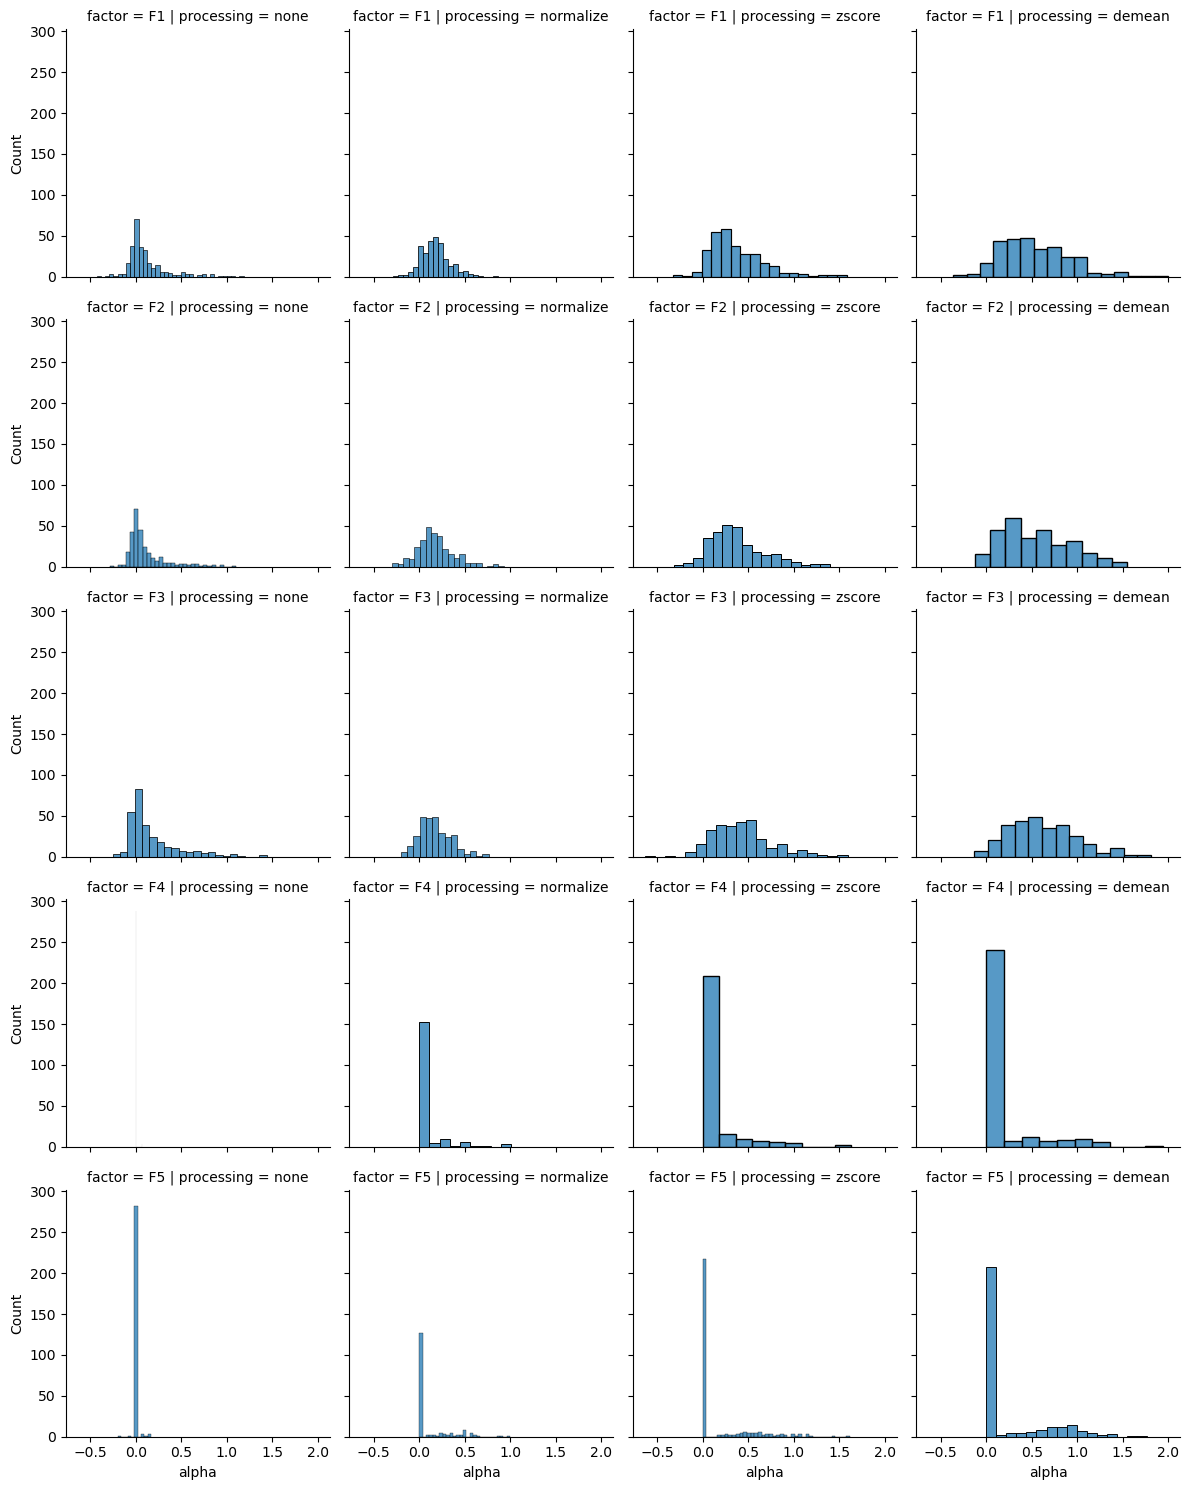

In [94]:
#factors =[ "F1_Close_Person_Worry","F2_Anxiety_Avoidance", "F3_Economic_Impact_Worry", "F4_Prob_Estimates", "F5_Worry", "F6_Skepticism"]
dd = pd.DataFrame()
for f_idx,f in enumerate(factors):
    data = df.groupby(["PROLIFICID", "session"]).agg({f: "mean", "state_severity": "mean"}).reset_index() #[["PROLIFICID", "stai_ta", "bdi","cat", "sticsa_ta", "sticsa_cog_ta", "sticsa_som_ta"]].mean()
    data2=data.rename(columns={f: "p", "state_severity": "o"})
    for proc in ["none", "normalize", "zscore", "demean"]:
        tdf = pd.DataFrame()
        tdf = df.groupby(["PROLIFICID"]).agg({"state_severity": "mean"}).reset_index().set_index("PROLIFICID")
        ttdf = pd.DataFrame()
        a = data2.groupby(["PROLIFICID"]).apply(func[lr_type],  adjust=proc)
        a.replace([np.inf, -np.inf], np.nan, inplace=True)
        ttdf = pd.DataFrame(a, columns=[lr_type])
        ttdf["processing"] = proc
        ttdf["factor"] = "F"+str(f_idx+1)
        tdf = tdf.join(ttdf)
        dd = pd.concat([dd, tdf])
        
#fig = plt.figure(figsize = (16,4))
#ax = fig.gca()
#a.hist(ax = ax, bins = 100) 
dd
g = sns.FacetGrid(dd,  row="factor", col="processing")
g.map_dataframe(sns.histplot, x=lr_type)


### Build alpha data set 

In [95]:
data
data2=data.rename(columns={f: "p", "state_severity": "o"})
data2

PROLIFICID  session    p         o
0     01S0stEpc3rU6YxK        0  6.0  0.088882
1     01S0stEpc3rU6YxK        1  3.0  0.088593
2     01S0stEpc3rU6YxK        2  3.0  0.047481
3     01S0stEpc3rU6YxK        3  3.0  0.019977
4     01S0stEpc3rU6YxK        4  3.0  0.011291
...                ...      ...  ...       ...
5820  ztPVSoIVH3QKpGeQ       15  6.0  0.485028
5821  ztPVSoIVH3QKpGeQ       16  7.0  0.652482
5822  ztPVSoIVH3QKpGeQ       17  7.0  0.665879
5823  ztPVSoIVH3QKpGeQ       18  5.0  0.393617
5824  ztPVSoIVH3QKpGeQ       19  7.0  0.359338

[5825 rows x 4 columns]

In [96]:


#trait_vars = ["TF1_Self_Consciousness", "TF2_Tranquility", "TF3_Catastrophizing","TF4_Physiological_Anx", "TF5_Depression", "TF6_Cognitive_Anx"]
#trait_vars_labels = ["Self-Consciousness", "Tranquility", "catastrophizing", "Physio_Anxiety", "Depression", "Cogn_Anxiety"]


trait_vars_ms = [ i+"_ms" for i in trait_factor_names]
trait_vars_ts = [ i+"_ts" for i in trait_factor_names]
df_alpha = pd.DataFrame()
for f_idx,f in enumerate(factors):
    data = df.groupby(["PROLIFICID", "session", "GROUP"]+trait_vars_ms+trait_vars_ts)[["state_severity", f]+trait_factor_names].mean().reset_index()
    data2=data.rename(columns={f: "p", "state_severity": "o"})
    for proc in ["normalize"]:
        tdf = pd.DataFrame()
        #tdf = df.groupby(["PROLIFICID"]).agg({"state_severity": "mean"}).reset_index().set_index("PROLIFICID")
        tdf = df.groupby(["PROLIFICID", "GROUP"]+trait_vars_ms+trait_vars_ts)[["state_severity"]+trait_factor_names].mean().reset_index().set_index("PROLIFICID")
        ttdf = pd.DataFrame()
        a = data2.groupby(["PROLIFICID"]).apply(func[lr_type],  adjust=proc)
        a.replace([np.inf, -np.inf], np.nan, inplace=True)
        ttdf = pd.DataFrame(a, columns=[lr_type])
        ttdf["processing"] = proc
        ttdf["factor"] = factors[f_idx]
        tdf = tdf.join(ttdf)
        df_alpha = pd.concat([df_alpha, tdf])

In [97]:
df_alpha

GROUP TF3_NegativeAffect_ms TF2_PhysiolAnx_ms  \
PROLIFICID                                                       
01S0stEpc3rU6YxK    UK                   low               low   
05c9AaLx1V20UAcO    BE                   low              high   
07GDvN1Nh0oHcEBM    UK                   low               low   
0OjnLzK5ABd2wO54    BE                   low              high   
0Pe1blVigsBRLvBj    UK                   low              high   
...                ...                   ...               ...   
zNbLeZqHa6wNHRLR    UK                   low               low   
zYWr4nlB9BwdVWFB    UK                  high              high   
zZGJnUM65XIz0F0X    UK                   low               low   
zlOEoLWEAwlLTGbE    UK                  high              high   
ztPVSoIVH3QKpGeQ    UK                   low              high   

                 TF1_CognAnxDepr_ms stai_ta_ms TF3_NegativeAffect_ts  \
PROLIFICID                                                             
01S0stEpc3rU6YxK                low       high                   mid   
05c9AaLx1V20UAcO               high        low                   low   
07GDvN1Nh0oHcEBM               high        low                   mid   
0OjnLzK5ABd2wO54                low        low                   mid   
0Pe1blVigsBRLvBj               high        low                   mid   
...                             ...        ...                   ...   
zNbLeZqHa6wNHRLR                low        low                   low   
zYWr4nlB9BwdVWFB               high       high                   mid   
zZGJnUM65XIz0F0X                low        low                   low   
zlOEoLWEAwlLTGbE               high       high                  high   
ztPVSoIVH3QKpGeQ                low        low                   low   

                 TF2_PhysiolAnx_ts TF1_CognAnxDepr_ts stai_ta_ts  \
PROLIFICID                                                         
01S0stEpc3rU6YxK               low                mid        mid   
05c9AaLx1V20UAcO              high               high        low   
07GDvN1Nh0oHcEBM               mid                mid        low   
0OjnLzK5ABd2wO54              high                low        low   
0Pe1blVigsBRLvBj               mid                mid        mid   
...                            ...                ...        ...   
zNbLeZqHa6wNHRLR               mid                low        low   
zYWr4nlB9BwdVWFB               mid                mid        mid   
zZGJnUM65XIz0F0X               mid                mid        mid   
zlOEoLWEAwlLTGbE              high               high       high   
ztPVSoIVH3QKpGeQ              high                mid        low   

                  state_severity  TF3_NegativeAffect  TF2_PhysiolAnx  \
PROLIFICID                                                             
01S0stEpc3rU6YxK        0.168602           -0.270737       -0.592381   
05c9AaLx1V20UAcO        0.184856           -1.495914        1.133909   
07GDvN1Nh0oHcEBM        0.176052           -0.437732       -0.394696   
0OjnLzK5ABd2wO54        0.185354           -0.298534        0.597397   
0Pe1blVigsBRLvBj        0.088937           -0.374222       -0.062450   
...                          ...                 ...             ...   
zNbLeZqHa6wNHRLR        0.140843           -1.342296       -0.386679   
zYWr4nlB9BwdVWFB        0.052076            0.105969        0.222751   
zZGJnUM65XIz0F0X        0.084731           -0.652928       -0.210182   
zlOEoLWEAwlLTGbE        0.085238            0.664146        0.676987   
ztPVSoIVH3QKpGeQ        0.185244           -1.453888        0.372510   

                  TF1_CognAnxDepr    stai_ta     alpha processing  \
PROLIFICID                                                          
01S0stEpc3rU6YxK        -0.262363  48.666667  0.084656  normalize   
05c9AaLx1V20UAcO         0.282148  32.333333  0.174185  normalize   
07GDvN1Nh0oHcEBM        -0.119848  38.000000 -0.029674  normalize   
0OjnLzK5ABd2wO54        -1.489741  34.333333  0.441879

['F1_CovidAnxietyWorry', 'F2_CovidProbabilityEsts', 'F3_Economic', 'q6_apply_soc_dist', 'q7_period_rel_danger']


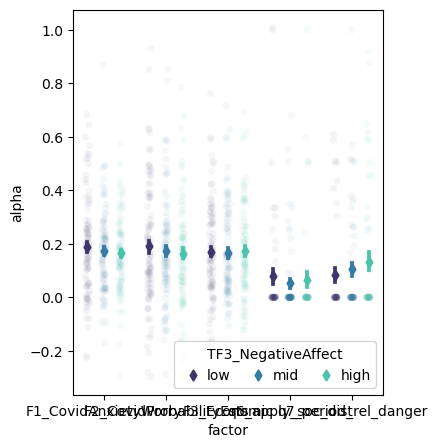

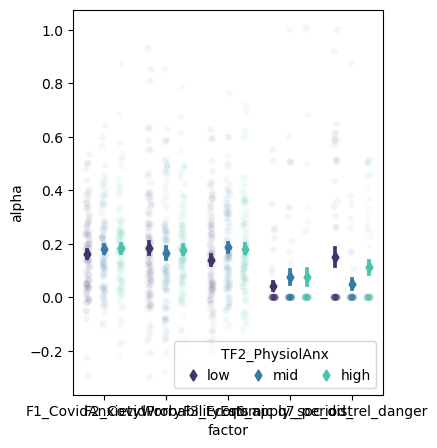

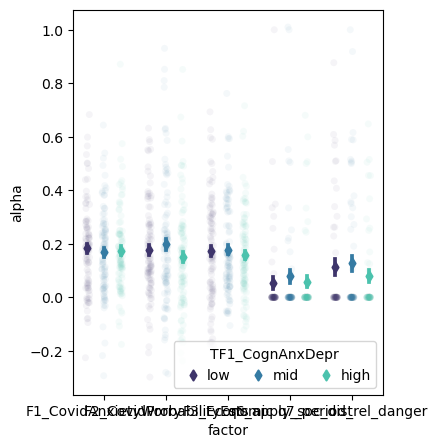

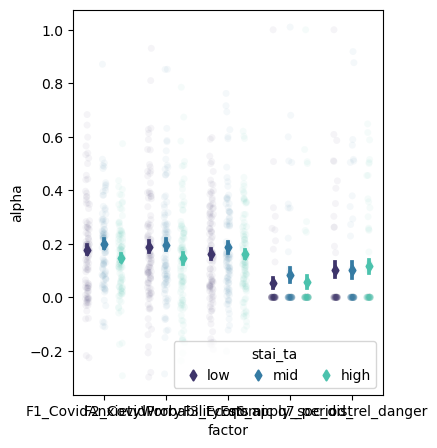

In [98]:
#for f_idx, f in enumerate(factors):
#    tdf = df_alpha.loc[df_alpha["factor"].isin(["F"+str(f_idx)]),:]
for tr_idx, tr in enumerate(trait_factor_names):
    plt.subplots(figsize=(4,5))
    dff=df_alpha.loc[:,["factor", lr_type, tr+"_ts"]].reset_index()

    g= sns.stripplot(x="factor", y=lr_type, hue=tr+"_ts", hue_order=["low", "mid", "high"], 
                  palette=sns.color_palette("mako",3),
                  data=dff, dodge=True, alpha=.05, zorder=1)


    g = sns.pointplot(x="factor", y=lr_type, hue=tr+"_ts", hue_order=["low", "mid", "high"],
                  palette=sns.color_palette("mako",3),
                  data=df_alpha, dodge=.8 - .8 / 3,
                  join=False, 
                  markers="d", scale=.75, ci=68 )

    handles, labels = g.get_legend_handles_labels()
    g.legend(handles[3:], labels[3:], title=trait_factor_names[tr_idx],
              handletextpad=0, columnspacing=1,
              loc="lower right", ncol=3, frameon=True)
print(factors)

In [99]:
print(df_alpha.shape)
df_alpha = df_alpha.dropna()
print(df_alpha.shape)
df_alpha

(1510, 17)
(1232, 17)


GROUP TF3_NegativeAffect_ms TF2_PhysiolAnx_ms  \
PROLIFICID                                                       
01S0stEpc3rU6YxK    UK                   low               low   
05c9AaLx1V20UAcO    BE                   low              high   
07GDvN1Nh0oHcEBM    UK                   low               low   
0OjnLzK5ABd2wO54    BE                   low              high   
0Pe1blVigsBRLvBj    UK                   low              high   
...                ...                   ...               ...   
yync642vyGNIN7Y9    UK                  high              high   
z1WzSMWJvLe818hc    UK                  high              high   
zNbLeZqHa6wNHRLR    UK                   low               low   
zYWr4nlB9BwdVWFB    UK                  high              high   
zlOEoLWEAwlLTGbE    UK                  high              high   

                 TF1_CognAnxDepr_ms stai_ta_ms TF3_NegativeAffect_ts  \
PROLIFICID                                                             
01S0stEpc3rU6YxK                low       high                   mid   
05c9AaLx1V20UAcO               high        low                   low   
07GDvN1Nh0oHcEBM               high        low                   mid   
0OjnLzK5ABd2wO54                low        low                   mid   
0Pe1blVigsBRLvBj               high        low                   mid   
...                             ...        ...                   ...   
yync642vyGNIN7Y9                low       high                   mid   
z1WzSMWJvLe818hc               high       high                  high   
zNbLeZqHa6wNHRLR                low        low                   low   
zYWr4nlB9BwdVWFB               high       high                   mid   
zlOEoLWEAwlLTGbE               high       high                  high   

                 TF2_PhysiolAnx_ts TF1_CognAnxDepr_ts stai_ta_ts  \
PROLIFICID                                                         
01S0stEpc3rU6YxK               low                mid        mid   
05c9AaLx1V20UAcO              high               high        low   
07GDvN1Nh0oHcEBM               mid                mid        low   
0OjnLzK5ABd2wO54              high                low        low   
0Pe1blVigsBRLvBj               mid                mid        mid   
...                            ...                ...        ...   
yync642vyGNIN7Y9              high                mid       high   
z1WzSMWJvLe818hc              high               high       high   
zNbLeZqHa6wNHRLR               mid                low        low   
zYWr4nlB9BwdVWFB               mid                mid        mid   
zlOEoLWEAwlLTGbE              high               high       high   

                  state_severity  TF3_NegativeAffect  TF2_PhysiolAnx  \
PROLIFICID                                                             
01S0stEpc3rU6YxK        0.168602           -0.270737       -0.592381   
05c9AaLx1V20UAcO        0.184856           -1.495914        1.133909   
07GDvN1Nh0oHcEBM        0.176052           -0.437732       -0.394696   
0OjnLzK5ABd2wO54        0.185354           -0.298534        0.597397   
0Pe1blVigsBRLvBj        0.088937           -0.374222       -0.062450   
...                          ...                 ...             ...   
yync642vyGNIN7Y9        0.158252            0.115850        1.851392   
z1WzSMWJvLe818hc        0.155211            0.612203        1.780481   
zNbLeZqHa6wNHRLR        0.140843           -1.342296       -0.386679   
zYWr4nlB9BwdVWFB        0.052076            0.105969        0.222751   
zlOEoLWEAwlLTGbE        0.085238            0.664146        0.676987   

                  TF1_CognAnxDepr    stai_ta     alpha processing  \
PROLIFICID                                                          
01S0stEpc3rU6YxK        -0.262363  48.666667  0.084656  normalize   
05c9AaLx1V20UAcO         0.282148  32.333333  0.174185  normalize   
07GDvN1Nh0oHcEBM        -0.119848  38.000000 -0.029674  normalize   
0OjnLzK5ABd2wO54        -1.489741  34.333333  0.441879

['F1_CovidAnxietyWorry', 'F2_CovidProbabilityEsts', 'F3_Economic', 'q6_apply_soc_dist', 'q7_period_rel_danger']


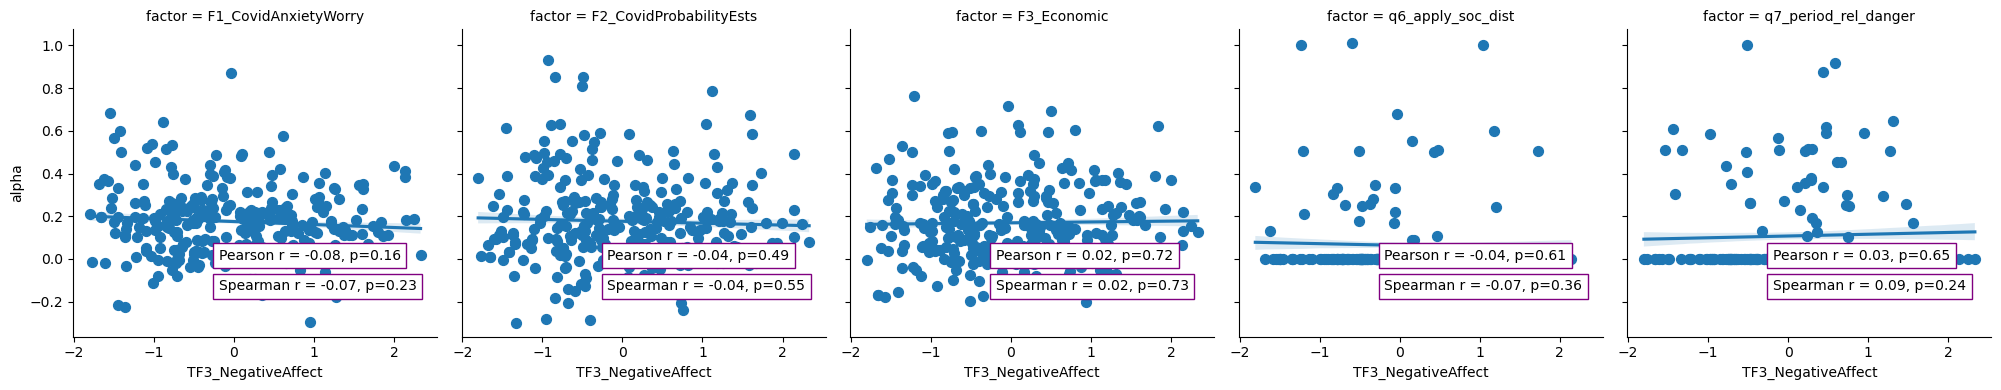

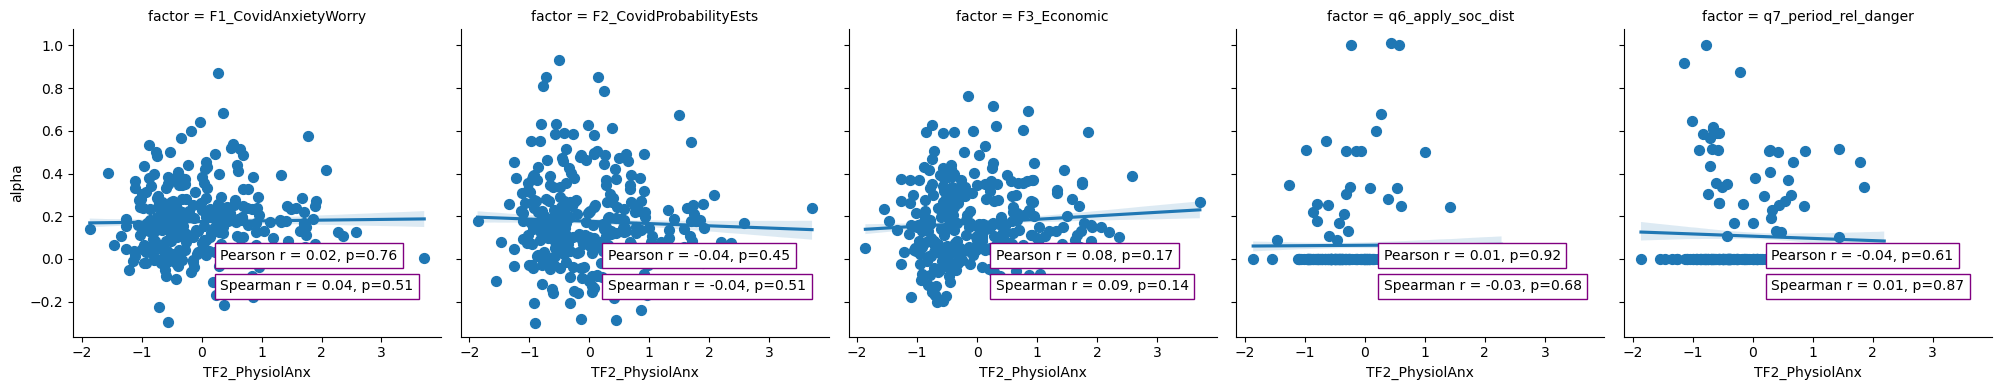

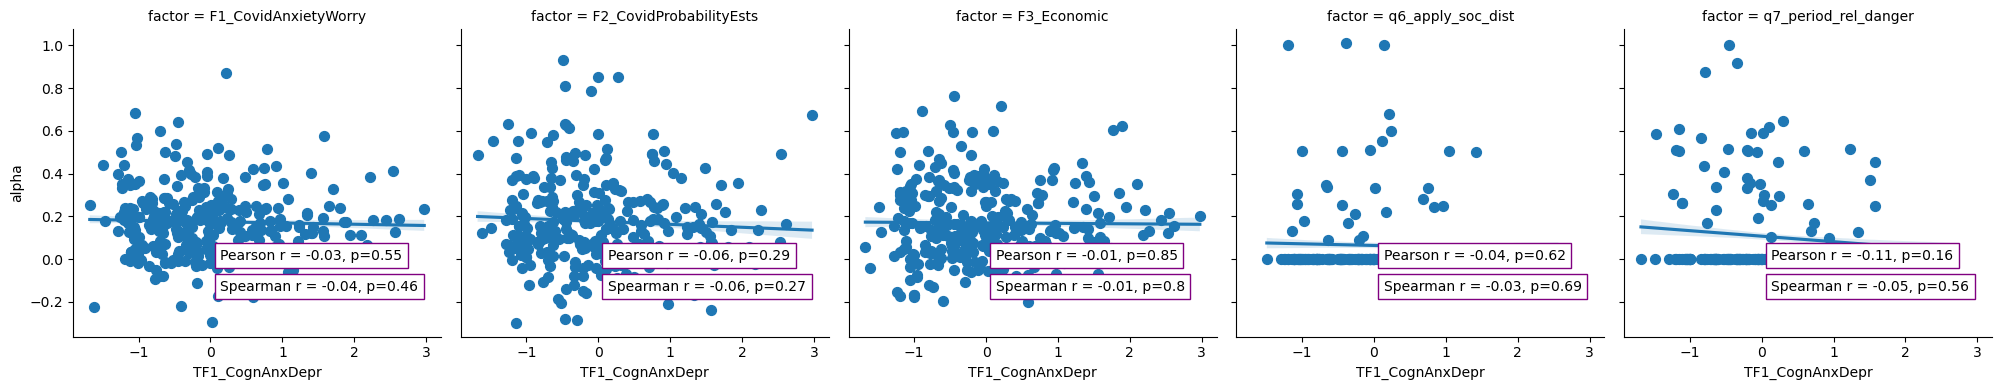

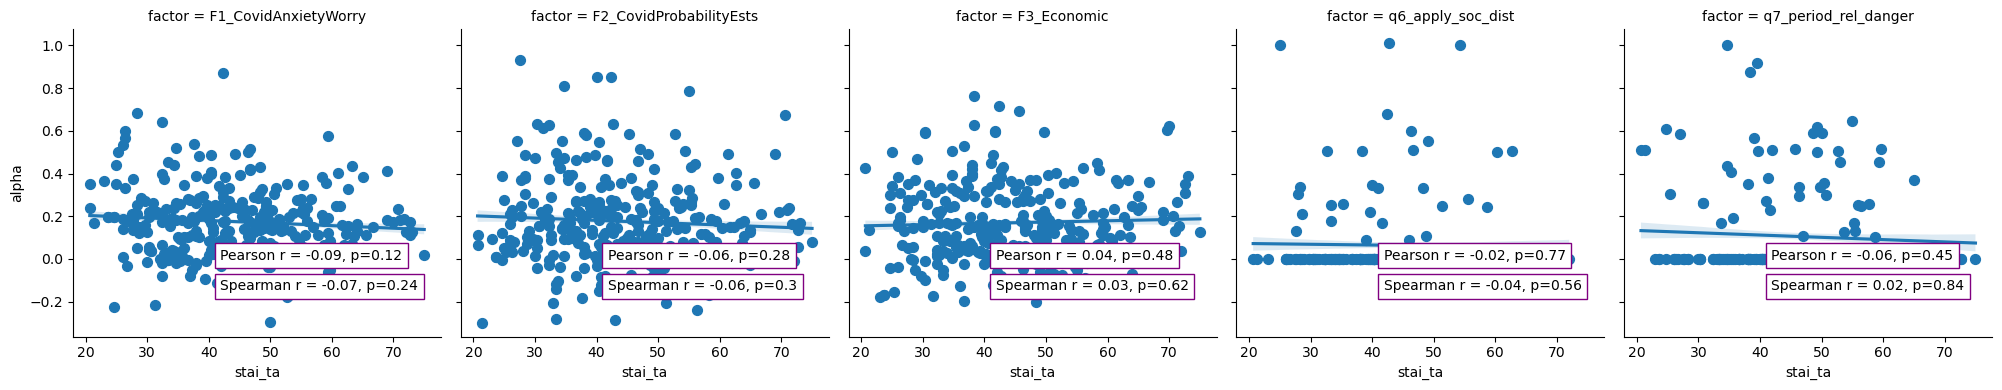

In [100]:
import seaborn as sns
import scipy as sp
for tr_idx, tr in enumerate(trait_factor_names):
    g = sns.lmplot(x=tr, y=lr_type, col="factor", data=df_alpha,
               col_wrap=6, ci=68, palette="muted", height=4, 
               scatter_kws={"s": 50, lr_type: 1})

    g.map(corrfunc, tr, lr_type, tests=["pearson", "spearman"])

print(factors)


### Export alphas for another analysis

In [101]:

df_alpha = pd.DataFrame()
for f_idx,f in enumerate(factors):
    data = df.groupby(["PROLIFICID", "session", "GROUP"])[["state_severity", f]].mean().reset_index()
    data2=data.rename(columns={f: "p", "state_severity": "o"})
    proc = "normalize"
    tdf = pd.DataFrame()
    #tdf = df.groupby(["PROLIFICID"]).agg({"state_severity": "mean"}).reset_index().set_index("PROLIFICID")
    tdf = df.groupby(["PROLIFICID"])[["stai_ta"]].mean().reset_index().set_index("PROLIFICID")
    ttdf = pd.DataFrame()
    a = data2.groupby(["PROLIFICID"]).apply(func[lr_type],  adjust=proc)
    a.replace([np.inf, -np.inf], np.nan, inplace=True)
    ttdf = pd.DataFrame(a, columns=[lr_type])
    ttdf["processing"] = proc
    ttdf["factor"] = factors[f_idx]
    tdf = tdf.join(ttdf)
    df_alpha = pd.concat([df_alpha, tdf])

In [102]:
factors = ["F1_CovidAnxietyWorry", "F2_CovidProbabilityEsts", "F3_Economic", "worryhealth", "q6_apply_soc_dist", "q7_period_rel_danger"]
fac_short = ["worry", "prob", "econ", "health", "socdist", "dangerperc"]

tdf = pd.DataFrame()
    #tdf = df.groupby(["PROLIFICID"]).agg({"state_severity": "mean"}).reset_index().set_index("PROLIFICID")
tdf = df.groupby(["PROLIFICID"])[["stai_ta"]].mean().reset_index().set_index("PROLIFICID")
for f_idx,f in enumerate(factors):
    data = df.groupby(["PROLIFICID", "session", "GROUP"])[["state_severity", f]].mean().reset_index()
    data2=data.rename(columns={f: "p", "state_severity": "o"})

    a = data2.groupby(["PROLIFICID"]).apply(func[lr_type],  adjust=proc)
    a.replace([np.inf, -np.inf], np.nan, inplace=True)
    ttdf = pd.DataFrame(a, columns=[lr_type+"_"+fac_short[f_idx]])
    #df_alpha = pd.concat([df_alpha, tdf])
    tdf = tdf.join(ttdf)
tdf.to_csv(os.path.join(root_dir, "output", "covid_alphas.csv"))

In [103]:
tdf

stai_ta  alpha_worry  alpha_prob  alpha_econ  \
PROLIFICID                                                         
01S0stEpc3rU6YxK  48.666667     0.084656    0.087111    0.027081   
05c9AaLx1V20UAcO  32.333333     0.174185   -0.003752    0.105589   
07GDvN1Nh0oHcEBM  38.000000    -0.029674    0.168500    0.390845   
0OjnLzK5ABd2wO54  34.333333     0.441879    0.143668    0.244830   
0Pe1blVigsBRLvBj  41.666667     0.033920    0.464456    0.600027   
...                     ...          ...         ...         ...   
zNbLeZqHa6wNHRLR  26.666667    -0.030759    0.080022    0.063916   
zYWr4nlB9BwdVWFB  44.333333     0.492826    0.085258    0.365965   
zZGJnUM65XIz0F0X  41.000000     0.223186    0.210420    0.335622   
zlOEoLWEAwlLTGbE  53.000000     0.194186    0.327276    0.356284   
ztPVSoIVH3QKpGeQ  31.333333    -0.217899    0.613396    0.165359   

                  alpha_health  alpha_socdist  alpha_dangerperc  
PROLIFICID                                                       
01S0stEpc3rU6YxK      0.000000            0.0               NaN  
05c9AaLx1V20UAcO      0.234696            0.0          0.000000  
07GDvN1Nh0oHcEBM      0.000000            0.0          0.000000  
0OjnLzK5ABd2wO54      0.194602            0.0          0.000000  
0Pe1blVigsBRLvBj      0.176795            0.0          0.000000  
...                        ...            ...               ...  
zNbLeZqHa6wNHRLR     -0.127466            0.0          0.000000  
zYWr4nlB9BwdVWFB      0.169034            0.0          0.000000  
zZGJnUM65XIz0F0X      0.240192            0.0               NaN  
zlOEoLWEAwlLTGbE      0.201188            0.0          0.454975  
ztPVSoIVH3QKpGeQ      0.258645            0.0               NaN  

[300 rows x 7 columns]